<a href="https://colab.research.google.com/github/mcurcio5/OOTM-Option-Pricing-with-Power-Laws-and-News/blob/master/alpha_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'Colab/Eric/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab/Eric


In [ ]:
!pip install yfinance

  Created wheel for yahoofinancials: filename=yahoofinancials-1.5-cp36-none-any.whl size=15195 sha256=bdf3da97933f6aeac361f49dbada39616ef28ad694ad6e986e8d28d1574bee0e
  Stored in directory: /root/.cache/pip/wheels/42/15/e7/240c5cdc8782b9479ba73404640a3be57bb4053a5c3edd6be5
Successfully built yahoofinancials
  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=fa28d5fbce52b61f3dccfea34fb733116d0e9b0666c0e6d88f2cb5a9d1126bb5
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from yahoofinancials import YahooFinancials
import numpy as np
import random
from scipy.special import zeta
from scipy.optimize import bisect
from datetime import datetime, timedelta

(0.001, 0.07439920576818249)

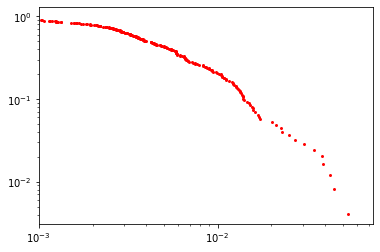

In [ ]:
#N = df_neg.shape[0] + df_pos.shape[0]
#print("N: ", N)
neg_sorted = df_neg.sort_values('change')
neg_sorted['prob'] = 1 - np.arange(neg_sorted.shape[0]) / neg_sorted.shape[0]
pos_sorted = df_pos.sort_values('change')
pos_sorted['prob'] = 1 - np.arange(pos_sorted.shape[0]) / pos_sorted.shape[0]
#plt.loglog(neg_sorted['change'], neg_sorted['prob'])
fig = plt.figure()
ax = plt.gca()
#ax.scatter(neg_sorted['change'], neg_sorted['prob'], c='blue', alpha=0.05, edgecolors='none')
ax.plot(neg_sorted['change'], neg_sorted['prob'], '.', c='red', markeredgecolor='none')
#ax.plot(pos_sorted['change'], pos_sorted['prob'], '.', c='blue', markeredgecolor='none')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(left = 10**-3)

[1.6579879468881056, 1.6798552823574013, 1.623689710349189, 1.6709571630817082, 1.6951046084861097, 1.6469404878343017, 1.672579451825166, 1.715691270919292, 1.6642443608086936, 1.6264000983827662, 1.6482911674106135, 1.6722741218896462, 1.6558798056324169, 1.6736273662170844, 1.645969678900094, 1.6830020303473074, 1.6588125159909937, 1.6875478732150726, 1.6618206704336016, 1.6608791041370727, 1.6697832280481528, 1.6724781630179055, 1.667742531767925, 1.6816421941920834, 1.6689069918472184, 1.74659163475775, 1.6203439796194772, 1.6437085547984482, 1.6393702254512827, 1.6448676582851816, 1.664200727301744, 1.6038869198923384, 1.6442272037891696, 1.6770953891408351, 1.670490932794755, 1.6898499162790306, 1.7065345036007518, 1.6925341011423642, 1.684850820154525, 1.6629419889313841, 1.6964965739746938, 1.6614245226628226, 1.6441237325396836, 1.745882649501068, 1.6674231109634166, 1.6152320019310151, 1.6411958657388397, 1.6510286560911056, 1.721076153875266, 1.6381326818592938, 1.630894302

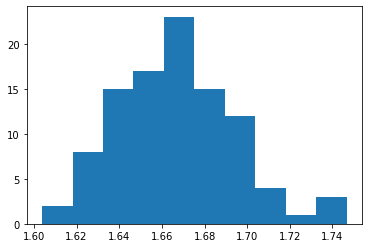

In [ ]:
dist1 = []
dist2 = []
n = 1000
for i in range(100):
  x = np.random.zipf(1.5, n)
  def log_zeta(x):
    return np.log(zeta(x,1))

  def log_deriv_zeta(x):
    h=1e-5
    return (log_zeta(x+h) - log_zeta(x-h))/(2*h)
  t = -np.sum(np.log(x/xmin))/n 
  def objective(x):
    return log_deriv_zeta(x) - t

  dist1.append(1 + n / np.sum(np.log(x)))
  dist2.append(bisect(objective, 1.01, 5, xtol = 1e-6))

plt.hist(dist2, bins = 10)
print(dist2)

In [ ]:
# want to predict whether option prices OOM execute
# get baseline for each stock's distribution
sp500 = pd.read_csv('./sp500-2017.csv')
sp500.head()

,Symbol,Name,Sector
0,MMM,3M Company,Industrials
1,AOS,A.O. Smith Corp,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie Inc.,Health Care
4,ACN,Accenture plc,Information Technology


In [ ]:
#select group of stocks
sample_size = 12
karmatta = .1

group = random.sample(list(sp500['Symbol']), sample_size)

- BF.B: No data found for this date range, symbol may be delisted


IndexError: ignored

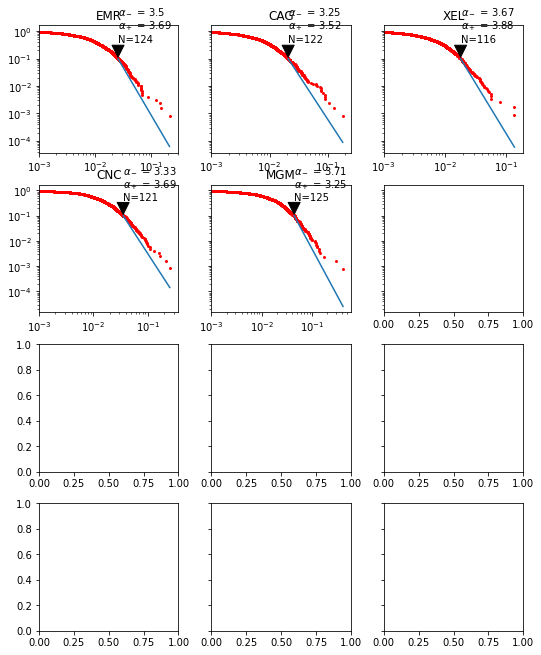

In [ ]:
# visualize alpha of stocks in SP500
fig, ax = plt.subplots(4,3,sharey='row')
fig.set_figheight(9)
fig.set_figwidth(7.5)
fig.tight_layout()
for i, symbol in enumerate(group):
  stock = yf.Ticker(symbol)
  df = stock.history(start='2010-01-01',
             end='2020-07-01',
             interval='1d')
  
  df['diff'] = np.log(df['Close'].div((df['Close'].shift(1))))
  df_neg = np.abs(df.loc[df['diff'] < 0])
  df_pos = df.loc[df['diff'] >= 0]

  # sort by move size and calculate cdf
  neg_sorted = df_neg.sort_values('diff')
  neg_sorted['prob'] = 1 - np.arange(neg_sorted.shape[0]) / neg_sorted.shape[0]
  pos_sorted = df_pos.sort_values('diff')
  pos_sorted['prob'] = 1 - np.arange(pos_sorted.shape[0]) / pos_sorted.shape[0]

  select_df = neg_sorted.loc[neg_sorted['prob'] < karmatta]
  size = select_df.shape[0]
  alpha_hat = get_alpha_cont(select_df)

  # neg sorted slope
  x = np.linspace(select_df['diff'][0], select_df['diff'][-1],num=50)
  k = select_df['prob'][0] * (x[0] ** (alpha_hat))
  y = k * (x ** (-alpha_hat))

  # now for positive
  select_df = pos_sorted.loc[pos_sorted['prob'] < karmatta]
  alpha_hat2 = get_alpha_cont(select_df)
  x_pos = np.linspace(select_df['diff'][0], select_df['diff'][-1],num=50)
  k = select_df['prob'][0] * (x[0] ** (alpha_hat2))
  y_pos = k * (x ** (-alpha_hat2))

  # display cdf
  r = i // 3
  c = i % 3
  ax[r,c].plot(neg_sorted['diff'], neg_sorted['prob'], '.', c='red', markeredgecolor='none')
  #ax[r,c].plot(pos_sorted['diff'], pos_sorted['prob'], '.', c='blue', markeredgecolor='none')
  ax[r,c].plot(x,y)
  #ax[r,c].plot(x_pos, y_pos)
  ax[r,c].set_yscale('log')
  ax[r,c].set_xscale('log')
  ax[r,c].set_xlim(left = 10**-3)
  ax[r,c].set_title(symbol)
  textstr = r'$\alpha_-$ = %s %s$\alpha_+$ = %s%sN=%s' % (np.round(alpha_hat, 2), '\n',
                                                    np.round(alpha_hat2, 2), '\n',size)
  ax[r,c].annotate(textstr, xy=(x[0], y[0]), xytext=(x[0], y[0]+.3),
            arrowprops=dict(facecolor='black', shrink=0.1))

2.0917552322149278


Text(0.8, 0.95, 'alpha: 2.09')

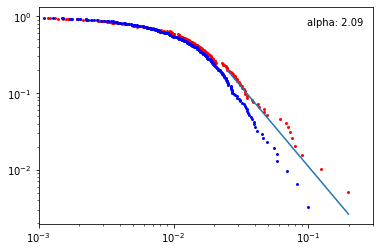

In [ ]:
stock = yf.Ticker('SPY')
df = stock.history(start='2010-01-01',
             end='2020-07-01',
             interval='1wk')
df['diff'] = np.log(df['Close'].div((df['Close'].shift(1)))) # log differences
#df['diff'].hist(bins = 100)
df_neg = np.abs(df.loc[df['diff'] < 0])
df_pos = df.loc[df['diff'] >= 0]
neg_sorted = df_neg.sort_values('diff')
neg_sorted['prob'] = 1 - np.arange(neg_sorted.shape[0]) / neg_sorted.shape[0]
pos_sorted = df_pos.sort_values('diff')
pos_sorted['prob'] = 1 - np.arange(pos_sorted.shape[0]) / pos_sorted.shape[0]


select_df = neg_sorted.loc[neg_sorted['prob'] < .2]
xmin = select_df['diff'][0]
t1 = -np.sum(np.log(select_df['diff']/xmin)) / select_df.shape[0]

def log_zeta(x):
  return np.log(zeta(x,1))

def log_deriv_zeta(x):
  h=1e-5
  return (log_zeta(x+h) - log_zeta(x-h))/(2*h)

def objective(x, t=t1):
  return log_deriv_zeta(x) - t

alpha_hat = bisect(objective, 1.01, 10, xtol = 1e-6)
print(alpha_hat)


#plt.loglog(neg_sorted['change'], neg_sorted['prob'])
fig = plt.figure()
ax = plt.gca()

# negative slope
x = np.linspace(select_df['diff'][0], select_df['diff'][-1],num=50)
k = select_df['prob'][0] * (x[0] ** (alpha_hat))
y = k * (x ** (-alpha_hat))

#ax.scatter(neg_sorted['change'], neg_sorted['prob'], c='blue', alpha=0.05, edgecolors='none')
ax.plot(neg_sorted['diff'], neg_sorted['prob'], '.', c='red', markeredgecolor='none')
ax.plot(pos_sorted['diff'], pos_sorted['prob'], '.', c='blue', markeredgecolor='none')
ax.plot(x, y)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(left = 10**-3)
textstr = "alpha: %s" % (np.round(alpha_hat, 2))
ax.text(0.8, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top')

In [ ]:
# get expected value for OOTM puts in SP500
# stock
karmatta = .2

stock = yf.Ticker('TSLA')
df = stock.history(start='2010-01-01',
            end='2020-07-30',
            interval='1d')

df['diff'] = np.log(df['Close'].div((df['Close'].shift(1))))
df_neg = np.abs(df.loc[df['diff'] < 0])
df_pos = df.loc[df['diff'] >= 0]

# sort by move size and calculate cdf
neg_sorted = df_neg.sort_values('diff')
neg_sorted['prob'] = 1 - np.arange(neg_sorted.shape[0]) / neg_sorted.shape[0]
pos_sorted = df_pos.sort_values('diff')
pos_sorted['prob'] = 1 - np.arange(pos_sorted.shape[0]) / pos_sorted.shape[0]

# alpha of downswings
select_df = neg_sorted.loc[neg_sorted['prob'] < karmatta]
alpha_hat = get_alpha_cont(select_df)
print("alpha neg: ", alpha_hat)

# alpha of upswings
pos_select_df = pos_sorted.loc[pos_sorted['prob'] < karmatta]
alpha_hat_pos = get_alpha_cont(pos_select_df)
print("alpha pos: ", alpha_hat_pos)

# current price - yesterday's closing
S0 = df.iloc[-1]['Close']
# get standard deviation for that time frame
stdev = np.sqrt(np.mean(df['diff']**2) - np.mean(df['diff'])**2)


alpha neg:  2.137000976204872
alpha pos:  2.125885391831398


In [ ]:
# subset for puts
df = pd.DataFrame(stock.option_chain(stock.options[expire_date]).puts)
subset = df.loc[(df['strike'] > K1*(1-.5*stdev)) & (df['strike'] < K1*(1+.5*stdev))]
# pick contract with most open interest as it's maybe priced most efficiently
subset = subset.iloc[[np.argmax(subset['openInterest'])]]
subset

In [ ]:
# price calls past Karmatta point
K1 = S * (1 + 3.5*stdev)

# subset for calls
df = pd.DataFrame(stock.option_chain(stock.options[expire_date]).calls)
subset = df.loc[(df['strike'] > K1*(1-.5*stdev)) & (df['strike'] < K1*(1+.5*stdev))]
# pick contract with most open interest as it's maybe priced most efficiently
subset = subset.iloc[[np.argmax(subset['openInterest'])]]

PK1 = float(subset['lastPrice'])
K1 = float(subset['strike'])
a = alpha_hat_pos
K2 = float(df.iloc[[278]]['strike'])

PK2 = PK1 * ((K2 - S0)/(K1 - S0))**(1-a)
print("Predicted Value: ", PK2)
print("Actual Price: ", df.iloc[278]['lastPrice'])

Predicted Value:  47.37844914878252
Actual Price:  72.0


In [ ]:
# get date of option

def get_index_call(stock, S0):
  # input is stock - output is the most liquid time frame for an option
  expire_index = 0
  days_till_exp = 0
  max_liquid = 0
  for i in range(len(stock.options)):
    d = datetime.strptime(stock.options[i], '%Y-%m-%d')
    d = d.date() - datetime.today().date()
    d = str(d).split()[0]
    if d == '0:00:00':
      continue
    # variable tracks the max number of liquid contracts in range
    if float(d) > 50 and float(d) < 100:
      # select contract with most liquidity in calls
      df = pd.DataFrame(stock.option_chain(stock.options[i]).calls)
      df = df.loc[(df['ask'] > 0) & (df['strike'] > S0)]
      # evaluate number of liquid contracts
      s = df.shape[0]
      if s > max_liquid:
        max_liquid = s
        expire_index = i
        days_till_exp = str(d).split(" ")[0]
    elif float(d) >= 100:
      break
  print("Days till exp: ", days_till_exp)
  if max_liquid == 0:
    raise ValueError("No liquid call contracts for time frame")
  return expire_index

def get_index_put(stock, S0):
  # input is stock - output is the most liquid time frame for an option
  expire_index = 0
  days_till_exp = 0
  max_liquid = 0
  for i in range(len(stock.options)):
    d = datetime.strptime(stock.options[i], '%Y-%m-%d')
    d = d.date() - datetime.today().date()
    d = str(d).split()[0]
    if d == '0:00:00':
      continue
    # variable tracks the max number of liquid contracts in range
    if float(d) > 50 and float(d) < 100:
      # select contract with most liquidity in calls
      df = pd.DataFrame(stock.option_chain(stock.options[i]).puts)
      df = df.loc[(df['ask'] > 0) & (df['strike'] < S0)]
      # evaluate number of liquid contracts
      s = df.shape[0]
      if s > max_liquid:
        max_liquid = s
        expire_index = i
        days_till_exp = str(d).split(" ")[0]
    elif float(d) >= 100:
      break
  print("Days till exp: ", days_till_exp)
  if max_liquid == 0:
    raise ValueError("No liquid call contracts for time frame")
  return expire_index



def get_k1_call(expire_index, stock, stdev, S0):
  df = pd.DataFrame(stock.option_chain(stock.options[expire_index]).calls)
  df = df.loc[df['ask'] > 0]
  print("df: ", df[['strike','ask','bid','volume']])
  subset = df.loc[(df['strike'] > S0*(1+3*stdev)) & (df['strike'] < S0*(1+4.5*stdev))]
  print("lower: ", S0*(1+3*stdev))
  print("Subset: ", subset)
  # pick contract with most volume as it's maybe priced most efficiently
  return subset.iloc[[0]]

def get_k1_put(expire_index, stock, stdev, S0):
  df = pd.DataFrame(stock.option_chain(stock.options[expire_index]).puts)
  df = df.loc[df['ask'] > 0]
  subset = df.loc[(df['strike'] < S0*(1-3*stdev)) & (df['strike'] > S0*(1-4.5*stdev))]
  print("Subset: ", subset)
  # pick contract with most volume as it's maybe priced most efficiently
  return subset.iloc[[np.argmin(subset['ask'] - subset['bid'])]]

In [ ]:
karmatta = .2

In [ ]:
# check current pricing of calls vs market for stock
def check_calls(symbol, start = '2010-01-01', end = '2020-07-30', interval='1d'):
  stock = yf.Ticker(symbol)
  df = stock.history(start=start, end=end, interval=interval)
  # get last price
  S0 = float(df.iloc[-1]['Close'])

  # get daily log changes
  df['diff'] = np.log(df['Close'].div((df['Close'].shift(1))))
  df_pos = df.loc[df['diff'] >= 0]

  # sort by move size and calculate cdf
  pos_sorted = df_pos.sort_values('diff')
  pos_sorted['prob'] = 1 - np.arange(pos_sorted.shape[0]) / pos_sorted.shape[0]

  # get alpha of positive movements
  select_df = pos_sorted.loc[pos_sorted['prob'] < karmatta]
  a = get_alpha_cont(select_df)
  
  stdev = np.sqrt(np.mean(df['diff']**2) - np.mean(df['diff'])**2)

  # get K1 df (reference option price at karmatta point)
  ind = get_index_call(stock, S0)
  k1_df = get_k1_call(ind, stock, stdev, S0)
  PK1 = float(k1_df['lastPrice'])
  K1 = float(k1_df['strike'])

  # get option table for those above K1
  above_k1_df = pd.DataFrame(stock.option_chain(stock.options[ind]).calls)
  above_k1_df = above_k1_df.loc[above_k1_df['strike'] > K1]
  above_k1_df['strike'] = above_k1_df['strike'].astype(float)
  print("S0: ", S0)
  # calculate value for each point above K1
  above_k1_df['model_value'] = PK1 * ((above_k1_df['strike'] - S0)/(K1 - S0))**(1-a)
  return above_k1_df

Days till exp:  76
df:       strike     ask     bid  volume
0     110.0  215.41  214.53     4.0
1     120.0  205.43  204.56    20.0
2     125.0  196.86  196.03   800.0
3     130.0  191.88  191.05  1200.0
4     135.0  186.90  186.06  1800.0
..      ...     ...     ...     ...
201   450.0    0.02    0.01     1.0
202   455.0    0.02    0.01     2.0
203   460.0    0.02    0.01     2.0
204   465.0    0.02    0.01     1.0
205   470.0    0.02    0.01    10.0

[206 rows x 4 columns]
lower:  335.76809510034474
Subset:           contractSymbol       lastTradeDate  ...  contractSize  currency
150  SPY201016C00336000 2020-07-31 19:36:01  ...       REGULAR       USD
151  SPY201016C00337000 2020-07-31 19:32:22  ...       REGULAR       USD
152  SPY201016C00338000 2020-07-31 19:41:24  ...       REGULAR       USD
153  SPY201016C00339000 2020-07-31 19:24:36  ...       REGULAR       USD
154  SPY201016C00340000 2020-07-31 19:59:12  ...       REGULAR       USD
155  SPY201016C00341000 2020-07-31 18:27:55  .

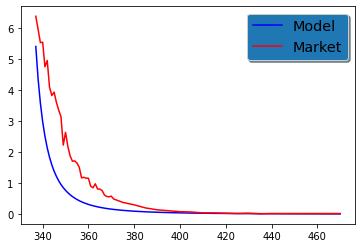

In [ ]:
d = check_calls('SPY')
fig, ax = plt.subplots()
ax.plot(d['strike'], d['model_value'], c="blue", label='Model')
ax.plot(d['strike'], d['lastPrice'],c="red", label='Market')
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C0')
plt.show()

In [ ]:
def check_puts(symbol,start = '2010-01-01', end = '2020-07-30', interval='1d'):
  stock = yf.Ticker(symbol)
  df = stock.history(start=start, end=end, interval=interval)
  # get last price
  S0 = float(df.iloc[-1]['Close'])

  # get daily log changes
  df['diff'] = np.log(df['Close'].div((df['Close'].shift(1))))
  df_neg = np.abs(df.loc[df['diff'] < 0])

  # sort by move size and calculate cdf
  neg_sorted = df_neg.sort_values('diff')
  neg_sorted['prob'] = 1 - np.arange(neg_sorted.shape[0]) / neg_sorted.shape[0]

  # get alpha of positive movements
  select_df = neg_sorted.loc[neg_sorted['prob'] < karmatta]
  print("Karmatta Deviation: ", select_df['diff'][0])
  a = get_alpha_cont(select_df)
  
  # get standard deviation over entire time frame
  stdev = np.sqrt(np.mean(df['diff']**2) - np.mean(df['diff'])**2)
  print("Standard Dev: ", stdev)

  # get K1 df (reference option price at karmatta point)
  ind = get_index_put(stock, S0)
  k1_df = get_k1_put(ind, stock, stdev, S0)
  PK1 = float(k1_df['lastPrice'])
  print(k1_df[['strike','lastPrice','bid','ask',]])
  print("PK1: ", PK1)
  K1 = float(k1_df['strike'])

  # get option table for those above K1
  below_k1_df = pd.DataFrame(stock.option_chain(stock.options[ind]).puts)
  below_k1_df = below_k1_df.loc[below_k1_df['strike'] < K1]
  below_k1_df['strike'] = below_k1_df['strike'].astype(float)
  print("S0: ", S0)
  # calculate value for each point below K1
  print("K1: ", K1)
  print(below_k1_df['strike'])
  num = ((-1)**(1-a)*(S0**(-a))*((a-1)*below_k1_df[['strike']] + S0) - 
          (below_k1_df[['strike']].astype(complex) - S0)**(1-a))
  print("num: ", num)
  denom = ((-1)**(1-a)*S0**(-a)*((a-1)*K1 + S0)) - (K1 - S0)**(1-a)
  below_k1_df['model_value'] = PK1 * num / denom
  return below_k1_df

Karmatta Deviation:  0.017815198010096817
Standard Dev:  0.010917092253470227
Days till exp:  76
Subset:           contractSymbol       lastTradeDate  ...  contractSize  currency
128  SPY201016P00310000 2020-07-31 20:00:28  ...       REGULAR       USD
129  SPY201016P00311000 2020-07-31 20:00:28  ...       REGULAR       USD
130  SPY201016P00312000 2020-07-31 19:02:15  ...       REGULAR       USD
131  SPY201016P00313000 2020-07-31 19:48:29  ...       REGULAR       USD
132  SPY201016P00314000 2020-07-31 19:59:26  ...       REGULAR       USD

[5 rows x 14 columns]
     strike  lastPrice   bid   ask
128   310.0       8.74  8.88  8.94
PK1:  8.74
S0:  325.12
K1:  310.0
0      110.0
1      115.0
2      120.0
3      125.0
4      130.0
       ...  
123    305.0
124    306.0
125    307.0
126    308.0
127    309.0
Name: strike, Length: 128, dtype: float64
num:       strike
0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
..      ...
123     NaN
124     NaN
125     NaN
126     NaN
127   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


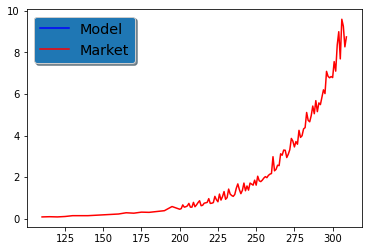

In [ ]:
d = check_puts('SPY')
fig, ax = plt.subplots()
ax.plot(d['strike'], d['model_value'], c="blue", label='Model')
ax.plot(d['strike'], d['lastPrice'],c="red", label='Market')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C0')
plt.show()

In [ ]:
stock

yfinance.Ticker object <APH>

In [ ]:
stock = yf.Ticker('SPY')
s = pd.DataFrame(stock.option_chain(stock.options[6]).calls)
s = s.loc[(s['ask'] > 0) & (s['inTheMoney'] == False)]
s

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
35,SPY200817C00327000,2020-07-31 19:57:18,327.0,4.29,4.73,4.79,0.29,7.249999,187.0,622,0.180733,False,REGULAR,USD
36,SPY200817C00328000,2020-07-31 19:37:39,328.0,3.35,4.16,4.22,0.06,1.823706,94.0,302,0.176766,False,REGULAR,USD
37,SPY200817C00329000,2020-07-31 20:05:16,329.0,3.66,3.63,3.69,0.70,23.648650,151.0,614,0.172982,False,REGULAR,USD
38,SPY200817C00330000,2020-07-31 19:59:32,330.0,3.00,3.14,3.19,0.04,1.351350,1250.0,3059,0.169015,False,REGULAR,USD
39,SPY200817C00331000,2020-07-31 19:57:05,331.0,2.37,2.68,2.74,-0.07,-2.868860,244.0,286,0.165536,False,REGULAR,USD
40,SPY200817C00332000,2020-07-31 19:57:26,332.0,1.99,2.27,2.32,0.02,1.015227,369.0,543,0.161813,False,REGULAR,USD
41,SPY200817C00333000,2020-07-31 20:08:32,333.0,1.89,1.90,1.94,-0.72,-27.586205,173.0,747,0.158151,False,REGULAR,USD
42,SPY200817C00334000,2020-07-31 19:37:59,334.0,1.37,1.57,1.61,-1.05,-43.388430,54.0,370,0.154977,False,REGULAR,USD
43,SPY200817C00335000,2020-07-31 20:14:00,335.0,1.28,1.29,1.33,0.05,4.065037,133.0,1287,0.152474,False,REGULAR,USD
44,SPY200817C00336000,2020-07-31 19:59:30,336.0,1.02,1.05,1.08,0.04,4.081629,364.0,1034,0.149667,False,REGULAR,USD


In [ ]:
# calculate best fit alpha on stock selection
def get_alpha(select_df):
  #print("select_df: ", select_df)
  xmin = select_df['diff'][0]
  t1 = -np.sum(np.log(select_df['diff']/xmin)) / select_df.shape[0]

  def log_zeta(x):
    return np.log(zeta(x,1))

  def log_deriv_zeta(x):
    h=1e-5
    return (log_zeta(x+h) - log_zeta(x-h))/(2*h)

  def objective(x, t=t1):
    return log_deriv_zeta(x) - t

  return bisect(objective, 1.01, 10, xtol = 1e-6)

In [ ]:
# for a stock, calculate xmin, alpha, KS stat and determine whether power law
def calc_emperical(df_sorted):
  # get quantile, alpha, and KS for best fit
  q, a, KS, xmin = get_xmin(df_sorted)
  print("True q: %s a: %s KS: %s xmin: %s" % (q,a,KS,xmin))
  p = calc_fit(df_sorted, q, a, KS, xmin)
  print("p: ",p)
  return p

def calc_fit(df_sorted, q, a, KS, xmin):
  # calculates whether the distribution with q, a is a power law
  # return value < .1 indicates distribution is not a power law
  # could be lognormal or exponential if N < 100-200
  KS_stats = []
  for i in range(2500):
    # generate dataset
    df = generate_dataset(df_sorted,q,a,xmin)
    q_local,a_local,KS_local,xminlocal = get_xmin(df)
    print("qlocal: %s  a_local: %s. KS: %s  xmin: %s" %(q_local,a_local,KS_local,xminlocal))
    KS_stats.append(KS_local)
  KS_stats=np.array(KS_stats)
  p = np.mean(KS_stats > KS)
  # if less than .1 generated datasets are greater than KS, no power law
  return p

def generate_dataset(df_sorted,q,a,xmin):
  # with prob ntail / ntotal -> from power law
  # 1 - that p -> from original dataset above q
  N = df_sorted.shape[0]
  df_below_xmin = df_sorted.loc[df_sorted['prob'] >= q]
  n_power = np.sum(np.random.uniform(0,1,N)<q)
  n_normal = N - n_power
  # generate n_power variables from power law
  r = np.random.uniform(0,1,n_power)
  x1 = xmin * (1 - r) ** (-1 / (a - 1))
  # generate n_normal variables from df_below_xmin
  x2 = np.random.choice(df_below_xmin['diff'], n_normal, replace=True)
  # make new dataframe
  df = df_sorted.drop(['diff'], axis=1)
  df['diff'] = list(np.sort(np.concatenate((x1,x2),axis=0)))
  #print(df[['diff']].tail())
  return df


def get_xmin(df_sorted):
  # input is either neg_sorted or pos_sorted
  # function gets quantile, alpha, and KS for best fit
  quants = [.2, .14, .10, .07, .035] # 100% of data - min quantile
  D, alphas1 = calc_KS(df_sorted, quants)
  # print("D1: ", D)
  # print("Alpha1: ", alphas1)
  # get indices of smallest D
  sorted = list(np.argsort(D))
  num_searches = 6 # number of searches over smaller range
  quants = list(np.linspace(quants[sorted[0]]-.025, quants[sorted[0]]+.025, num = num_searches))
  D2, alphas2 = calc_KS(df_sorted, quants)
  # D2.insert(0, D[sorted[0]])
  # alphas2.insert(0,alphas1[sorted[0]])
  # D2.append(D[sorted[1]])
  # alphas2.append(alphas1[sorted[1]])
  # print("D2: ", D2)
  # print("Alpha2: ", alphas2)
  index = np.argmin(D2)
  # get quantile of best KS stat
  quant = np.round(quants[index], 3)
  # get alpha of that quantile
  alpha = alphas2[index]
  # get KS of that quantile
  KS = D2[index]
  # get xmin
  xmin = df_sorted['diff'].loc[df_sorted['prob'] < quant].iloc[0]
  return quant, alpha, KS, xmin

def calc_KS(df_sorted, quantiles):
  D = []
  alphas = []
  for i in range(len(quantiles)):
    # get subset for min quantile
    df = df_sorted.loc[df_sorted['prob'] < quantiles[i]]
    a = get_alpha_cont(df) # get alpha for that subset
    alphas.append(a)
    # calculate cdf for subset
    df['cdf'] = 1 - np.arange(df.shape[0])/df.shape[0]
    # cdf for power law is zeta(a,x) / zeta(a,xmin)
    xmin = df['diff'].iloc[0]
    df['zeta'] = zeta(a,df['diff'])/zeta(a,xmin)
    # get KS Statistic on that subset
    D.append(np.max(np.abs(df['cdf'] - df['zeta'])/np.sqrt(df['zeta']*(1 - df['zeta']))))
    # note: D is inf when a is too low
  return D, alphas


In [ ]:
pd.options.mode.chained_assignment = None
stock = yf.Ticker('TSLA')
df = stock.history(start = '2010-01-01', end = '2020-07-30', interval='1d')

# get daily log changes
df['diff'] = np.log(df['Close'].div((df['Close'].shift(1))))
df_neg = np.abs(df.loc[df['diff'] < 0])

# sort by move size and calculate cdf
neg_sorted = df_neg.sort_values('diff')
neg_sorted['prob'] = 1 - np.arange(neg_sorted.shape[0]) / neg_sorted.shape[0]

calc_emperical(neg_sorted)

True q: 0.145 a: 3.385192193556607 KS: 0.4416641014372932 xmin: 0.04185499302199967
qlocal: 0.225  a_local: 3.1614612179645643. KS: 0.4290786068970602  xmin: 0.0324412890927455
qlocal: 0.215  a_local: 3.329638475881438. KS: 0.39308925703588665  xmin: 0.03125757937207403
qlocal: 0.055  a_local: 3.824406307329879. KS: 0.4082037659771094  xmin: 0.06863130140905398
qlocal: 0.155  a_local: 3.25915460255393. KS: 0.41918773749825106  xmin: 0.040821994520255166
qlocal: 0.105  a_local: 3.3366732987929932. KS: 0.4674452608979431  xmin: 0.04637410021889186
qlocal: 0.215  a_local: 3.1801128681509074. KS: 0.41899790762257666  xmin: 0.033044977015897536
qlocal: 0.205  a_local: 3.201261335731552. KS: 0.463446248003906  xmin: 0.03468486048971132
qlocal: 0.075  a_local: 3.9347005363541774. KS: 0.3840990356916858  xmin: 0.0577997657267071
qlocal: 0.155  a_local: 3.0385612181888404. KS: 0.5350009733055744  xmin: 0.042660858447512426
qlocal: 0.135  a_local: 3.7402745024711694. KS: 0.3546823927007762  xmin

0.5348

In [ ]:
def get_alpha_cont(select_df):
  n = select_df.shape[0]
  xmin = select_df['diff'][0]
  a = 1 + n / np.sum(np.log(select_df['diff']/xmin))
  return a

In [ ]:
def get_a_range(a, xmin, N):
  alphas = []
  for i in range(200):
    # generate continuous power law data
    r = np.random.uniform(0,1,N)
    x1 = np.sort(xmin * (1 - r) ** (-1 / (a - 1)))
    select_df = pd.DataFrame(data=x1, columns=['diff'])
    alphas.append(get_alpha_cont(select_df).astype(float))
  alphas = np.sort(np.array(alphas))
  # get lower and upper bound for alpha
  stdev = np.mean(alphas**2 - np.mean(alphas)**2)
  a_lower, a_upper = (a*(1-stdev*2), a*(1+stdev*2))
  return a_lower, a_upper

get_a_range(3,.1,200)

(2.8916796731150383, 3.1083203268849617)

Text(0.03871103892686858, 0.3947288006111535, '$\\alpha_-$ = 4.72 \nN=124')

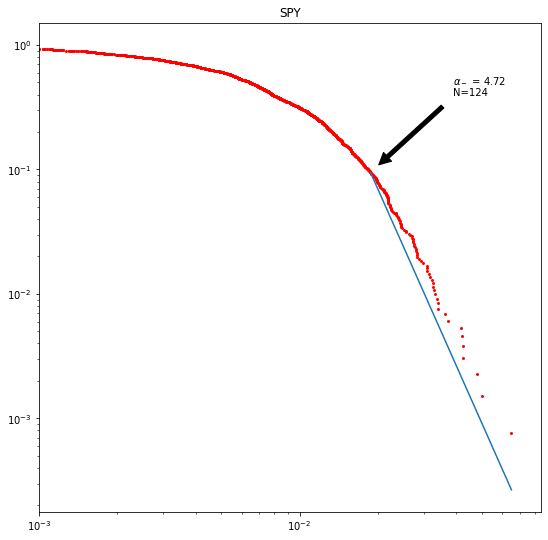

In [ ]:
pd.options.mode.chained_assignment = None
stock = yf.Ticker('EUO')
df = stock.history(start = '2010-01-01', end = '2020-08-04', interval='1d')

# get daily log changes
df['diff'] = np.log(df['Close'].div((df['Close'].shift(1))))
df_neg = np.abs(df.loc[df['diff'] < 0])
df_pos = df.loc[df['diff'] >= 0]

# sort by move size and calculate cdf
neg_sorted = df_neg.sort_values('diff')
neg_sorted['prob'] = 1 - np.arange(neg_sorted.shape[0]) / neg_sorted.shape[0]

q, alpha_hat, KS, xmin = get_xmin(neg_sorted)

select_df = neg_sorted.loc[neg_sorted['prob'] < q]
size = select_df.shape[0]

# neg sorted slope
x = np.linspace(select_df['diff'][0], select_df['diff'][-1],num=50)
k = select_df['prob'][0] * (x[0] ** (alpha_hat))
y = k * (x ** (-alpha_hat))

# now for positive
pos_sorted = df_pos.sort_values('diff')
pos_sorted['prob'] = 1 - np.arange(pos_sorted.shape[0]) / pos_sorted.shape[0]
q, alpha_hat2, KS, xmin = get_xmin(pos_sorted)
select_df = pos_sorted.loc[pos_sorted['prob'] < q]
size2 = select_df.shape[0]

x_pos = np.linspace(select_df['diff'][0], select_df['diff'][-1],num=50)
k = select_df['prob'][0] * (x[0] ** (alpha_hat2))
y_pos = k * (x ** (-alpha_hat2))

fig, ax = plt.subplots()
fig.set_figheight(9)
fig.set_figwidth(9)

ax.plot(neg_sorted['diff'], neg_sorted['prob'], '.', c='red', markeredgecolor='none')
#ax.plot(pos_sorted['diff'], pos_sorted['prob'], '.', c='blue', markeredgecolor='none')
ax.plot(x,y)
#ax.plot(x_pos, y_pos)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(left = 10**-3)
ax.set_title('SPY')
textstr = r'$\alpha_-$ = %s %sN=%s' % (np.round(alpha_hat, 2),'\n',size)
#textstr2 = r'$\alpha_+$ = %s %sN=%s' % (np.round(alpha_hat2, 2),'\n',size2)
plt.annotate(textstr, xy=(x[0], y[0]), xytext=(x[0]+.02, y[0]+.3),
          arrowprops=dict(facecolor='black', shrink=0.1))
# plt.annotate(textstr2, xy=(x_pos[0], y_pos[0]), xytext=(x_pos[0], y_pos[0]+.3),
#           arrowprops=dict(facecolor='black', shrink=0.1))

In [ ]:
# see if for one stock, the return dist graph makes sense
